# Well log analysis using BaySeg

In [1]:
import numpy as np
import pandas as pd
import importlib
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats
import seaborn as sns

import sys
sys.path.append("../")
import bayseg

C:\Users\Public\Anaconda3\lib\site-packages\gempy\posterior_analysis.py:24: UserWarning: pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.")


**Parameter setting**

In [2]:
n = 100 # number of iterations

**Data import**

In [3]:
data = pd.read_csv("../data/training_data.csv")                         # load the data from excel sheet
data.head()                                                             # display the last rows of data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


**Facies setting**

Not needed in case of raw data, because no interpretation is done

In [4]:
facies_classes = np.unique(data["Facies"])                                      # create facies indicies (1-9)
n_facies_classes = len(facies_classes)                                          # number of facies classes
print('The number of facies is' ,n_facies_classes,'called', facies_classes)

The number of facies is 9 called [1 2 3 4 5 6 7 8 9]


**Data setting**

In [9]:
feature_names =  ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND','PE']    # define data that are considered by headers from excel sheet(Gamma Ray,Induction, Neutron-density, delta Neutron-density, Photoelectric effect)
feature_vectors = data[feature_names]                             # create matrix including the data + headers
boreholes = ['SHRIMPLIN']
coords = np.array(data["Depth"].values).T                       # creating vector with depth information (z in [m])

**Normalize data**

In [6]:
def normalize_feature_vectors(feature_vectors):      # function to normalize data (x - mean / sigma)
    return (feature_vectors - np.mean(feature_vectors, axis=0).T) / np.std(feature_vectors, axis=0)

feature_vectors_norm = normalize_feature_vectors(feature_vectors.values) # normalize data (.values just takes the values not the header and indicies)

**Bayesian Information Criterion**

In [7]:
nf, nft = bayseg.test_bic(feature_vectors_norm)

The optimal number of layers is:  13


In [10]:
bayseg.bic(feature_vectors_norm, 25)      # Investigate the number of labels (one label can include several cluster)

TypeError: bic() missing 1 required positional argument: 'plot'

**Perform BaySeg Segmentation**

In [ ]:
clf = bayseg.BaySeg(feature_vectors_norm, 9, data, feature_names, boreholes, gp_resolution = 30 )

In [7]:
clf.fit(10, 
        beta_jump_length=2, 
        mu_jump_length=0.0005, 
        cov_volume_jump_length=0.00005, 
        theta_jump_length=0.0000005, verbose=False)

TypeError: __init__() missing 4 required positional arguments: 'raw_data', 'feature_names', 'boreholes', and 'gp_resolution'

In [11]:
clf.storage_

[array([[ 1.34547492, 46.16742399, 15.35952187, ..., 14.96750905,
          2.79382428, 14.0755928 ],
        [ 4.86832331, 19.47855262,  8.3936625 , ..., 19.51540743,
          7.84420798, 23.79659815],
        [ 6.85823626,  7.93947209,  4.19133092, ..., 22.5449685 ,
          9.1483948 , 28.7105083 ],
        ...,
        [-2.39007212,  6.61594246,  8.56113037, ...,  2.27242623,
          1.88202981,  4.34610985],
        [-2.02346294,  5.85163411,  8.51087048, ...,  2.23985733,
          1.92434812,  4.80953175],
        [-2.25692638,  5.97223633,  9.0400732 , ...,  2.07420583,
          1.04337286,  3.26493086]]),
 array([[ 1.3639754 , 46.46498662, 15.31412105, ..., 14.76696904,
          2.79289863, 14.24299688],
        [ 4.92754956, 19.57958281,  8.38299673, ..., 19.39028691,
          7.93114674, 23.9927952 ],
        [ 6.943074  ,  7.96260631,  4.19426523, ..., 22.44655913,
          9.3218205 , 28.90370102],
        ...,
        [-2.40189046,  6.60485462,  8.58946509, ...,  

**Convert data for Gempy input**

In [10]:
formation = clf.labels[-1]         # vector with final labeling, but including all wells
well_names = data['Well Name']        # list with all well names + indicies
well_names = list(set(data['Well Name']))    # list with all well names, but just once (8 boreholes)

gempy = pd.DataFrame({'X': np.zeros(len(formation)) ,'Y' : np.zeros(len(formation)),'Z' : coords ,'formation' : formation, 'borehole': data['Well Name']})       # Fill-gempy data

# create random X and Y information for each well
for i in range(0,len(well_names)):    # range from 0-8 (8 boreholes) 
    a =(np.where(data == well_names[i])[0])       # indicies of each borehole in data.file
    gempy.loc[a[0]:a[-1]+1,'X'] = i*250          # random X to each borehole
    gempy.loc[a[0]:a[-1]+1,'Y'] = i*500          # random Y to each borehole

In [11]:
#gempy.to_csv('Gempy_input_all_for_smoothing.csv')

In [12]:
# smoothing 
for k in range(1,len(gempy)-1):
    if gempy.loc[k,'formation'] != gempy.loc[k+1,'formation'] and gempy.loc[k,'formation'] != gempy.formation[k-1]:  # deletes 1x values
          gempy.loc[k,'formation'] = gempy.formation[k-1]
            
    elif gempy.loc[k,'formation'] != gempy.loc[k-1,'formation'] and gempy.loc[k,'formation'] != gempy.loc[k+2,'formation']: # deletes 2x values
          gempy.loc[k,'formation'] = gempy.loc[k-1,'formation']
    
    elif gempy.loc[k,'formation'] != gempy.loc[k-1,'formation'] and gempy.loc[k,'formation'] != gempy.loc[k+3,'formation']: # deletes 3x values
          gempy.loc[k,'formation'] = gempy.loc[k-1,'formation']
            
    elif gempy.loc[k,'formation'] != gempy.loc[k-1,'formation'] and gempy.loc[k,'formation'] != gempy.loc[k+4,'formation']: # deletes 4x values
          gempy.loc[k,'formation'] = gempy.loc[k-1,'formation']
    
    elif gempy.loc[k,'formation'] != gempy.loc[k-1,'formation'] and gempy.loc[k,'formation'] != gempy.loc[k+5,'formation']: # deletes 5x values
          gempy.loc[k,'formation'] = gempy.loc[k-1,'formation']

    elif gempy.loc[k,'formation'] != gempy.loc[k-1,'formation'] and gempy.loc[k,'formation'] != gempy.loc[k+6,'formation']: # deletes 6x values
          gempy.loc[k,'formation'] = gempy.loc[k-1,'formation']
            
    elif gempy.loc[k,'formation'] != gempy.loc[k-1,'formation'] and gempy.loc[k,'formation'] != gempy.loc[k+7,'formation']: # deletes 7x values
          gempy.loc[k,'formation'] = gempy.loc[k-1,'formation']
    
    else: continue
        
gempy.loc[0,'formation'] = gempy.loc[1,'formation']     # ensures first value to be equal second
#gempy.formation[-1] = gempy.formation[len(gempy.formation)-2]    # ensures last value to be equal second last

In [13]:
for k in range(0,len(gempy)-1):
    if gempy.loc[k,'formation'] == gempy.loc[k+1,'formation']:
        gempy = gempy.drop(k)
gempy.index = range(len(gempy))        

In [14]:
#gempy

In [15]:
gempy.formation = (gempy.formation +1) # no zero in the formation otherwise problems with plotting and strata_series
gempy.to_csv('Gempy_input.csv',index=False)

In [16]:
test = pd.read_csv("Gempy_input.csv")
test.tail()

,X,Y,Z,borehole,formation
114,0.0,0.0,3003.5,NEWBY,8
115,0.0,0.0,3017.0,NEWBY,2
116,0.0,0.0,3023.0,NEWBY,7
117,0.0,0.0,3057.0,NEWBY,5
118,1000.0,2000.0,2926.5,CHURCHMAN BIBLE,4
119,1000.0,2000.0,2938.5,CHURCHMAN BIBLE,5
120,1000.0,2000.0,2944.0,CHURCHMAN BIBLE,4
121,1000.0,2000.0,2973.5,CHURCHMAN BIBLE,5
122,1000.0,2000.0,2985.5,CHURCHMAN BIBLE,3
123,1000.0,2000.0,2991.0,CHURCHMAN BIBLE,1


**GemPy**

In [17]:
# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Public\Anaconda3\lib\site-packages\gempy\posterior_analysis.py:24: UserWarning: pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.")


In [18]:
# Importing the data from CSV-files and setting extent and resolution
geo_data = gp.create_data([0,2000,0,2000,0,2000],[10,10,10], 
                          path_o = "Gempy_input_f.csv", # importing orientation (foliation) data
                          path_i = "Gempy_input.csv") # importing point-positional interface data

In [19]:
geo_data.interfaces['formation'] = geo_data.interfaces['formation'].astype(str)
geo_data.orientations['formation'] = geo_data.orientations['formation'].astype(str)

In [20]:
#gp.get_data(geo_data, verbosity=1)

In [21]:
# Assigning series to formations as well as their order (timewise)
gp.set_series(geo_data, {"Unknown": ('1','2', '3', '4','5','6','7','8','9')},
                       order_series = ["Strat_Series"],
                       order_formations=['1','2', '3', '4','5','6','7','8','9'], verbose=0) 

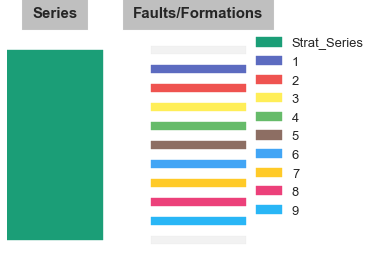

In [22]:
%matplotlib inline
gp.get_sequential_pile(geo_data)

In [23]:
print(gp.get_grid(geo_data))

[[ 100.  100.  100.]
 [ 100.  100.  300.]
 [ 100.  100.  500.]
 ...
 [1900. 1900. 1500.]
 [1900. 1900. 1700.]
 [1900. 1900. 1900.]]


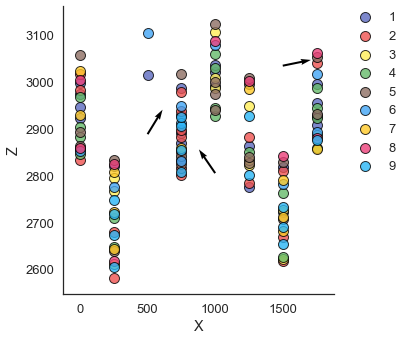

In [24]:
%matplotlib inline
gp.plot_data(geo_data, direction='y')

In [25]:
#gp.plot_data_3D(geo_data)

In [26]:
# u_grade depends on number of series (one series [1], two series [1,1]...) 
interp_data = gp.InterpolatorData(geo_data, u_grade=[1], output='geology', compile_theano=True, theano_optimizer='fast_compile')

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


In [27]:
interp_data.geo_data_res.get_formation_number()

{'1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 'DefaultBasement': 0}

In [28]:
gp.get_kriging_parameters(interp_data)

range 0.49487165 3464.1015231609344
Number of drift equations [3]
Covariance at 0 0.005830904
orientations nugget effect 0.01
scalar nugget effect 1e-06


In [29]:
lith_block, fault_block = gp.compute_model(interp_data)

C:\Users\Public\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.371920215793466e-09 / 5.960464477539063e-08
  RuntimeWarning)


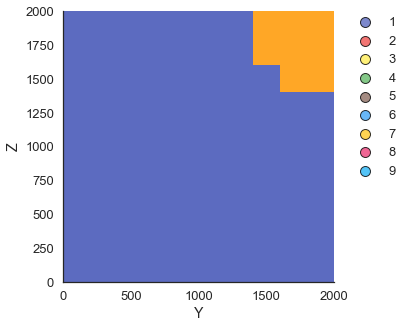

In [30]:
gp.plot_section(geo_data, lith_block[0], cell_number=9,  direction='x', plot_data=True)

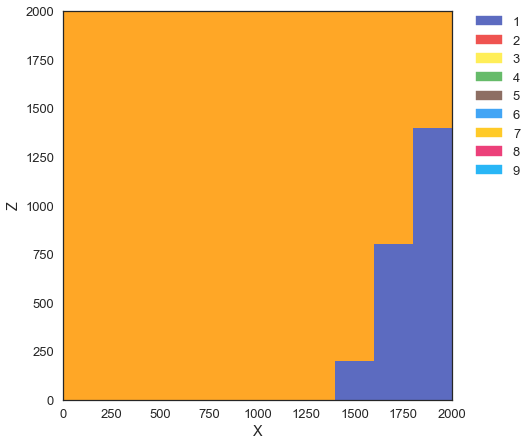

In [31]:
gp.plot_section(geo_data, lith_block[0], 9)

In [32]:
ver, sim = gp.get_surfaces(interp_data,lith_block[1], fault_block[1], original_scale=True)

IndexError: index 1 is out of bounds for axis 0 with size 0